In [1]:
from pathlib import Path
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow as tf
import torch
import torch.nn.functional as F
from einops import parse_shape, rearrange, reduce
from IPython.display import Image, display
from matplotlib.patches import Rectangle
from osc.data.clevr_with_masks import get_iterator
from osc.data.utils import normalize_tf, unnormalize_pt
from osc.models.vit import ViTBackbone
from sklearn.cluster import KMeans
from timm.models import vision_transformer
from timm.models.helpers import load_custom_pretrained
from torchvision.transforms import Normalize


def ln(x):
    return F.layer_norm(x, (x.shape[-1],))


p = Path("scratch/")
p.mkdir(exist_ok=True)

2022-04-28 14:09:06.517453: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(1000000, 4) (549605, 4)


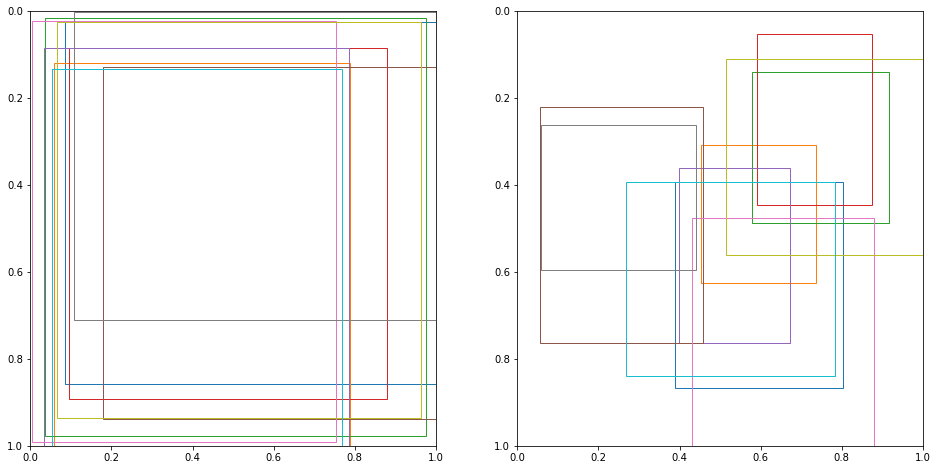

In [2]:
def generate_random_boxes(area_min, area_max, ratio_min, ratio_max, N, seed):
    rng = np.random.default_rng(seed)
    area = rng.uniform(area_min, area_max, size=(N,))
    ratio = rng.uniform(ratio_min, ratio_max, size=(N,))
    h = np.sqrt(area / ratio)
    w = np.sqrt(area * ratio)
    keep = (h <= 1) & (w <= 1)
    h = h[keep]
    w = w[keep]
    i = rng.uniform(0, 1 - h)
    j = rng.uniform(0, 1 - w)
    # [N', (y0 x0 y1 x1)]
    return np.stack([i, j, i + h, j + w], axis=-1)


small_boxes = tf.constant(
    generate_random_boxes(
        area_min=0.08,
        area_max=0.25,
        ratio_min=2 / 3,
        ratio_max=3 / 2,
        N=1_000_000,
        seed=123,
    ),
    dtype=tf.float32,
)
large_boxes = tf.constant(
    generate_random_boxes(
        area_min=0.6,
        area_max=1.0,
        ratio_min=2 / 3,
        ratio_max=3 / 2,
        N=1_000_000,
        seed=456,
    ),
    dtype=tf.float32,
)
print(small_boxes.shape, large_boxes.shape)

fig, axs = plt.subplots(1, 2, figsize=(16, 8), facecolor="white")
for idx, (y0, x0, y1, x1) in enumerate(large_boxes[:10]):
    axs[0].add_patch(Rectangle((x0, y0), y1 - y0, x1 - x0, fill=False, color=f"C{idx}"))
for idx, (y0, x0, y1, x1) in enumerate(small_boxes[:10]):
    axs[1].add_patch(Rectangle((x0, y0), y1 - y0, x1 - x0, fill=False, color=f"C{idx}"))
for ax in axs:
    ax.set_xlim([0, 1])
    ax.set_ylim([1, 0])

## Example image

(120, 120, 3)


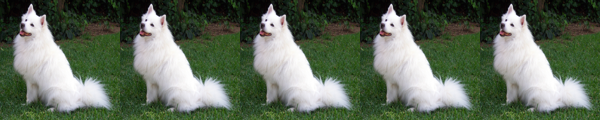

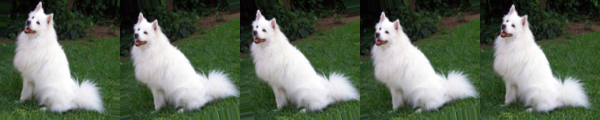

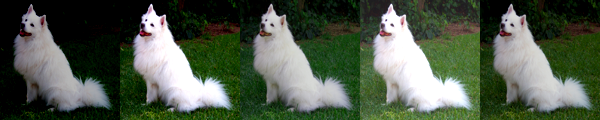

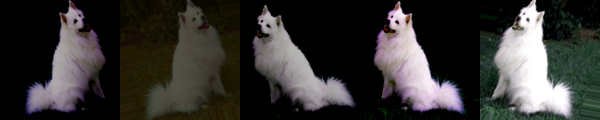

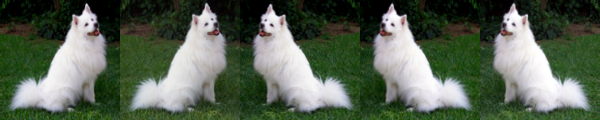

In [3]:
img = PIL.Image.open("dog.jpg").resize((120, 120))
print(np.array(img).shape)
# display(img)

img = tf.image.convert_image_dtype(tf.constant(np.array(img)), tf.float32)
ds = tf.data.Dataset.zip(
    (
        tf.data.Dataset.from_tensors(img).repeat(),
        tf.data.Dataset.random(42).map(
            lambda s: tf.random.experimental.create_rng_state(s, "threefry")
        ),
    )
)

imgs = ds.map(lambda img, s: img).batch(5).take(1).get_single_element()
imgs = tf.image.convert_image_dtype(imgs, tf.uint8).numpy()
display(PIL.Image.fromarray(rearrange(imgs, "B H W C -> H (B W) C")))


def geometric_augment_np(img, seed, strength):
    # img must be single image [H W RGB]
    shear_max = 15 * strength
    rot_max = 30 * strength
    rng = np.random.default_rng(seed)
    shear = rng.uniform(-shear_max, shear_max)
    rot = rng.uniform(-rot_max, rot_max)
    return tf.keras.preprocessing.image.apply_affine_transform(
        img, shear=shear, theta=rot
    )


@tf.function
def geometric_augment(img, seed, strength):
    seeds = tf.random.experimental.stateless_split(seed, 2)
    img = tf.image.stateless_random_flip_left_right(img, seeds[0])
    seed_np = tf.random.stateless_uniform([], seeds[1], None, None, dtype=tf.uint32)
    img = tf.numpy_function(geometric_augment_np, [img, seed_np, strength], tf.float32)
    return img


imgs = (
    ds.map(lambda img, s: geometric_augment(img, s, strength=0.5))
    .batch(5)
    .take(1)
    .get_single_element()
)
imgs = tf.image.convert_image_dtype(imgs, tf.uint8).numpy()
display(PIL.Image.fromarray(rearrange(imgs, "B H W C -> H (B W) C")))


@tf.function
def color_augment(img, seed, strength):
    brightness = 0.6 * strength
    contrast = 0.8 * strength
    saturation = 0.8 * strength
    hue = 0.2 * strength
    seeds = tf.random.experimental.stateless_split(seed, 4)
    img = tf.image.stateless_random_saturation(
        img, 1 - saturation, 1 + saturation, seeds[0]
    )
    img = tf.image.stateless_random_brightness(img, brightness, seeds[1])
    img = tf.image.stateless_random_contrast(img, 1 - contrast, 1 + contrast, seeds[2])
    img = tf.image.stateless_random_hue(img, hue, seeds[3])
    img = tf.clip_by_value(img, 0, 1)
    return img


imgs = (
    ds.map(lambda img, s: color_augment(img, s, strength=0.5))
    .batch(5)
    .take(1)
    .get_single_element()
)
imgs = tf.image.convert_image_dtype(imgs, tf.uint8).numpy()
display(PIL.Image.fromarray(rearrange(imgs, "B H W C -> H (B W) C")))


@tf.function
def augment(img, seed, strength):
    seeds = tf.random.experimental.stateless_split(seed, 2)
    img = color_augment(img, seeds[0], strength)
    img = geometric_augment(img, seeds[1], strength)
    return img


imgs = (
    ds.map(lambda img, s: augment(img, s, strength=0.9))
    .batch(5)
    .take(1)
    .get_single_element()
)
imgs = tf.image.convert_image_dtype(imgs, tf.uint8).numpy()
display(PIL.Image.fromarray(rearrange(imgs, "B H W C -> H (B W) C")))

imgs = (
    ds.map(lambda img, s: augment(img, s, strength=0.1))
    .batch(5)
    .take(1)
    .get_single_element()
)
imgs = tf.image.convert_image_dtype(imgs, tf.uint8).numpy()
display(PIL.Image.fromarray(rearrange(imgs, "B H W C -> H (B W) C")))

## CLEVR Strong augs

max_brightness=0.4


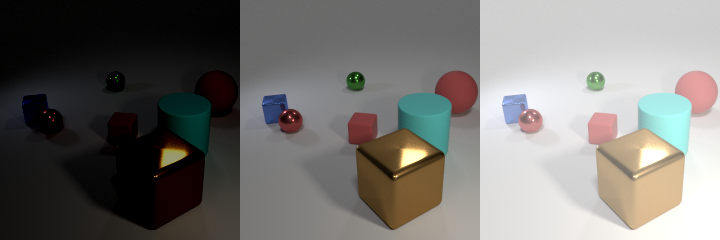

max_saturation=0.5


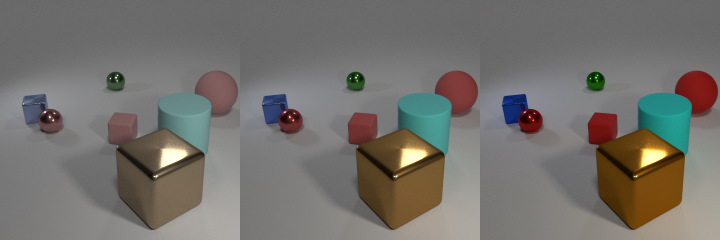

max_contrast=0.5


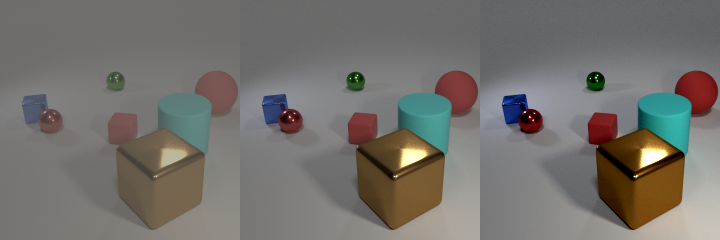

max_hue=0.03


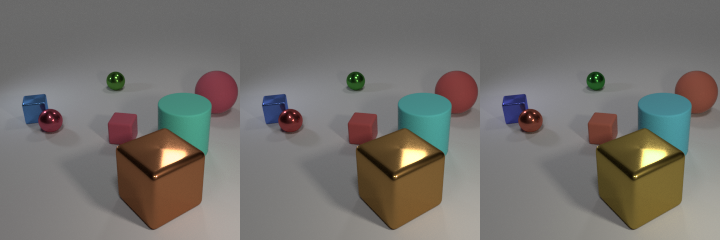

In [7]:
max_brightness = 0.4
max_saturation = 0.5
max_contrast = 0.5
max_hue = 0.03

img = (
    get_iterator("~/multi-object-datasets/", numpy=False)
    .map(lambda x: tf.image.convert_image_dtype(x["image"], tf.float32))
    .take(1)
    .get_single_element()[:, :240]
)

print(f"{max_brightness=}")
display(
    PIL.Image.fromarray(
        tf.image.convert_image_dtype(
            tf.concat(
                (
                    tf.clip_by_value(
                        tf.image.adjust_brightness(img, -max_brightness), 0, 1
                    ),
                    img,
                    tf.clip_by_value(
                        tf.image.adjust_brightness(img, max_brightness), 0, 1
                    ),
                ),
                axis=1,
            ),
            np.uint8,
        ).numpy()
    )
)

print(f"{max_saturation=}")
display(
    PIL.Image.fromarray(
        tf.image.convert_image_dtype(
            tf.concat(
                (
                    tf.image.adjust_saturation(img, 1 - max_saturation),
                    img,
                    tf.image.adjust_saturation(img, 1 + max_saturation),
                ),
                axis=1,
            ),
            np.uint8,
        ).numpy()
    )
)

print(f"{max_contrast=}")
display(
    PIL.Image.fromarray(
        tf.image.convert_image_dtype(
            tf.concat(
                (
                    tf.clip_by_value(
                        tf.image.adjust_contrast(img, 1 - max_contrast), 0, 1
                    ),
                    img,
                    tf.clip_by_value(
                        tf.image.adjust_contrast(img, 1 + max_contrast), 0, 1
                    ),
                ),
                axis=1,
            ),
            np.uint8,
        ).numpy()
    )
)

print(f"{max_hue=}")
display(
    PIL.Image.fromarray(
        tf.image.convert_image_dtype(
            tf.concat(
                (
                    tf.image.adjust_hue(img, -max_hue),
                    img,
                    tf.image.adjust_hue(img, max_hue),
                ),
                axis=1,
            ),
            np.uint8,
        ).numpy()
    )
)

## Large/small crops

center | large | large | small | small | small


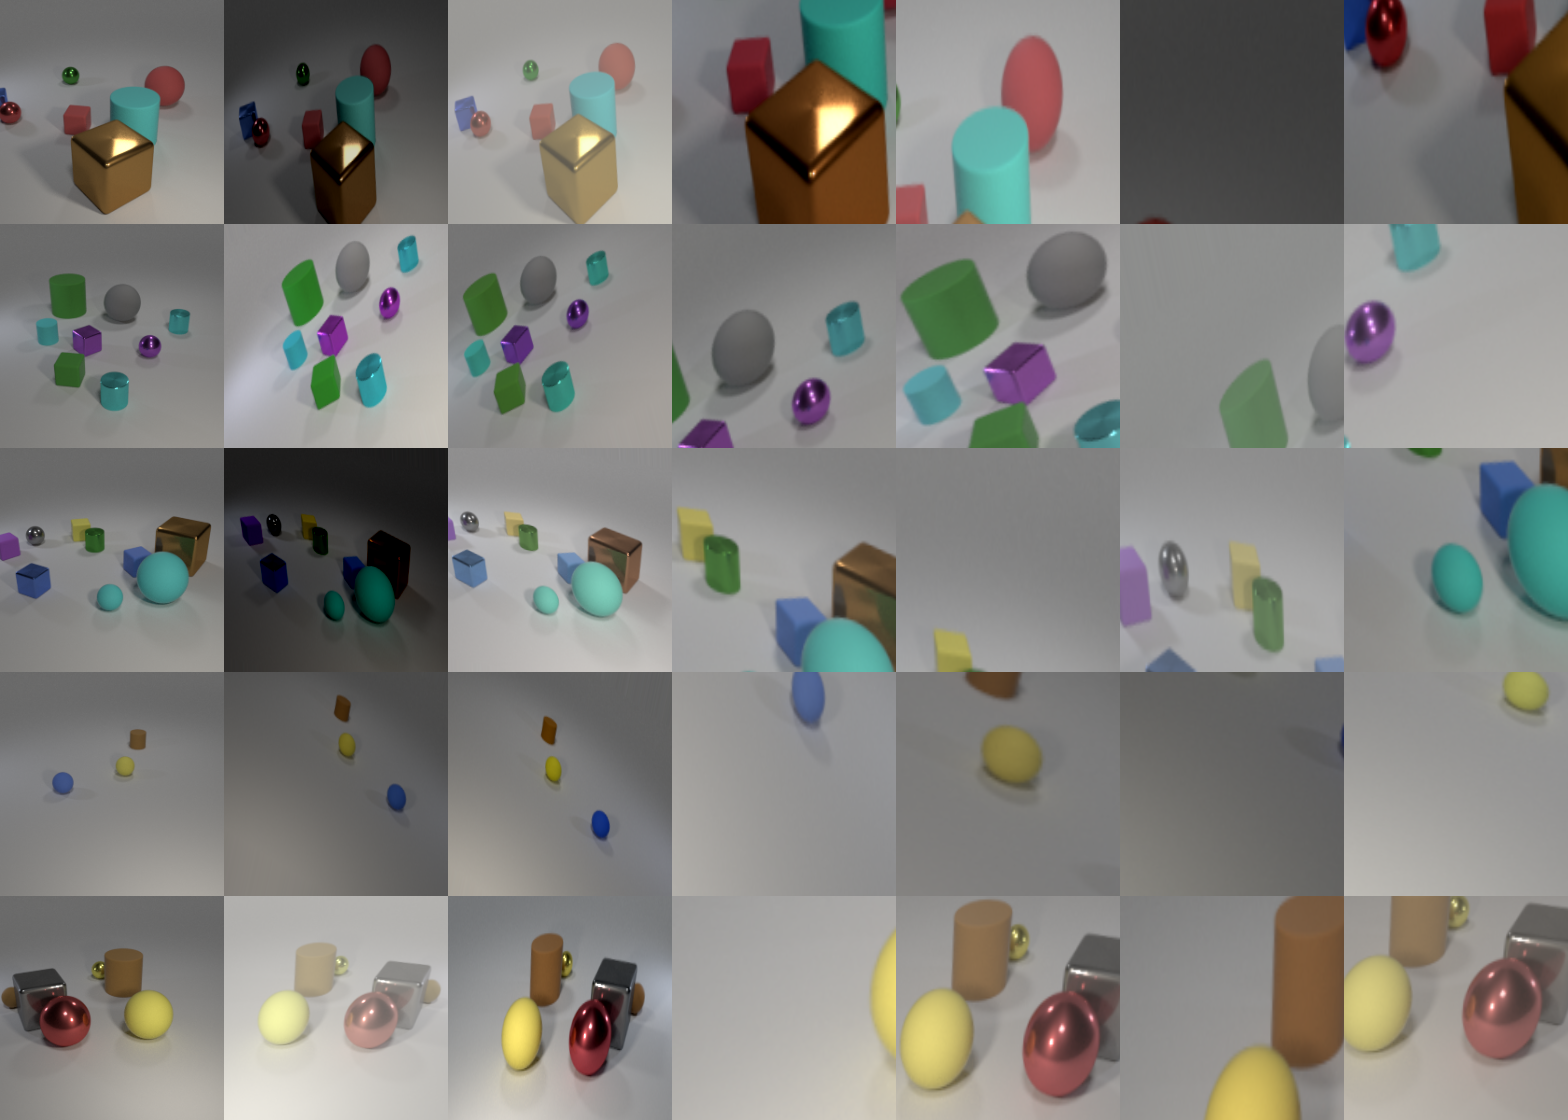

In [8]:
@tf.function
def crops(img, seed):
    img = tf.image.convert_image_dtype(img, tf.float32)
    imgs = tf.tile(img[None, ...], [4, 1, 1, 1])
    seeds = tf.random.experimental.stateless_split(seed, 5)

    large_idxs = tf.random.stateless_uniform(
        [2], seeds[0], minval=0, maxval=len(large_boxes), dtype=tf.int32
    )
    small_idxs = tf.random.stateless_uniform(
        [2], seeds[0], minval=0, maxval=len(small_boxes), dtype=tf.int32
    )
    boxes_ijhw = tf.concat(
        (
            tf.gather(large_boxes, large_idxs, axis=0),
            tf.gather(small_boxes, small_idxs, axis=0),
        ),
        axis=0,
    )
    imgs = tf.image.crop_and_resize(imgs, boxes_ijhw, tf.range(4), [224, 224])
    imgs = color_augment(imgs, seeds[2])

    return imgs


@tf.function
def color_augment(img, seed, strength):
    brightness = 0.3 * strength
    contrast = 0.4 * strength
    saturation = 0.4 * strength
    hue = 0.03 * strength
    seeds = tf.random.experimental.stateless_split(seed, 4)
    img = tf.image.stateless_random_saturation(
        img, 1 - saturation, 1 + saturation, seeds[0]
    )
    img = tf.image.stateless_random_brightness(img, brightness, seeds[1])
    img = tf.image.stateless_random_contrast(img, 1 - contrast, 1 + contrast, seeds[2])
    img = tf.image.stateless_random_hue(img, hue, seeds[3])
    img = tf.clip_by_value(img, 0, 1)
    return img


@tf.function
def augment(
    img,
    seed,
    strength: float,
    num_large: int = 2,
    num_small: int = 4,
    crop_size: (int, int) = (224, 224),
):
    orig = tf.keras.preprocessing.image.smart_resize(img, crop_size)

    seeds = tf.random.experimental.stateless_split(seed, 3)
    img = geometric_augment(img, seeds[0], strength)

    seeds_large = tf.random.experimental.stateless_split(seeds[1], 1 + num_large)
    large = tf.random.stateless_uniform(
        [num_large], seeds_large[0], minval=0, maxval=len(large_boxes), dtype=tf.int32
    )
    large = tf.gather(large_boxes, large, axis=0)
    large = tf.image.crop_and_resize(
        img[None, ...], large, tf.zeros(num_large, dtype=tf.int32), crop_size
    )
    large = tf.map_fn(
        lambda x: color_augment(x[0], x[1], strength),
        (large, seeds_large[1:]),
        fn_output_signature=tf.float32,
    )

    seeds_small = tf.random.experimental.stateless_split(seeds[2], 1 + num_small)
    small = tf.random.stateless_uniform(
        [num_small], seeds_small[0], minval=0, maxval=len(small_boxes), dtype=tf.int32
    )
    small = tf.gather(small_boxes, small, axis=0)
    small = tf.image.crop_and_resize(
        img[None, ...], small, tf.zeros(num_small, dtype=tf.int32), crop_size
    )
    small = tf.map_fn(
        lambda x: color_augment(x[0], x[1], strength * 0.6),
        (small, seeds_small[1:]),
        fn_output_signature=tf.float32,
    )

    return tf.concat((orig[None, ...], large, small), axis=0)


# [C H W] np.uint8
ds = tf.data.Dataset.zip(
    (
        get_iterator("~/multi-object-datasets/", numpy=False).map(
            lambda x: tf.image.convert_image_dtype(x["image"], tf.float32),
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=True,
        ),
        tf.data.Dataset.random(seed=123).map(
            lambda s: tf.random.create_rng_state(s, "threefry"),
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=True,
        ),
    )
)

imgs = (
    ds.map(
        lambda img, s: augment(img, s, strength=1.0),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    .batch(5)
    .take(1)
    .get_single_element()
)
imgs = tf.image.convert_image_dtype(imgs, tf.uint8).numpy()
print("center", "large", "large", "small", "small", "small", sep=" | ")
display(PIL.Image.fromarray(rearrange(imgs, "B A H W C -> (B H) (A W) C")))

Get a batch of images.

In [9]:
num_large = 3
num_small = 4

imgs = (
    ds.map(
        lambda img, s: augment(
            img, s, strength=1.0, num_large=num_large - 1, num_small=num_small
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    .map(lambda x: normalize_tf(x, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]))
    .batch(2)
    .map(lambda x: tf.transpose(x, [0, 1, 4, 2, 3]))  # B A H W C -> B A C H W
    .take(1)
    .get_single_element()
)
imgs_th = torch.from_numpy(imgs.numpy())
B, A, _, Hi, Wi = imgs_th.shape
tuple(imgs_th.shape), imgs_th.dtype, imgs_th.min(), imgs_th.max()

((2, 7, 3, 224, 224), torch.float32, tensor(-1.), tensor(1.))

In [10]:
imgs_np = unnormalize_pt(imgs_th, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
imgs_np = rearrange(imgs_np, "B A C H W -> B A H W C")
imgs_np.shape, imgs_np.dtype, imgs_np.min(), imgs_np.max()

(torch.Size([2, 7, 224, 224, 3]), torch.float32, tensor(0.), tensor(1.))

In [106]:
from timm.models.vision_transformer import vit_base_patch8_224_dino

m = vit_base_patch8_224_dino(pretrained=True)
m.eval()
x = m.forward_features(rearrange(imgs_th, 'B A C H W ->(B A) C H W')).detach()
x = rearrange(x[:, 1:], '(B A) (H W) C -> B A H W C', B=2, H=28)
x.shape

torch.Size([2, 7, 28, 28, 768])

centering False
temperature 0.1


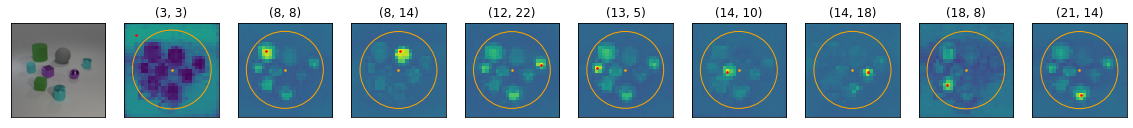

centering False
temperature 1


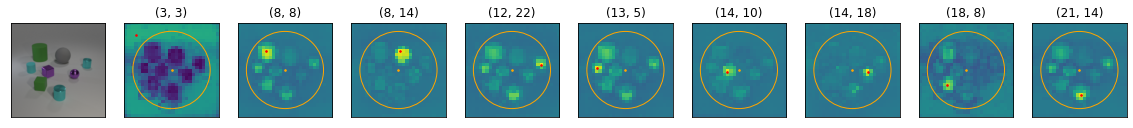

centering False
temperature 10


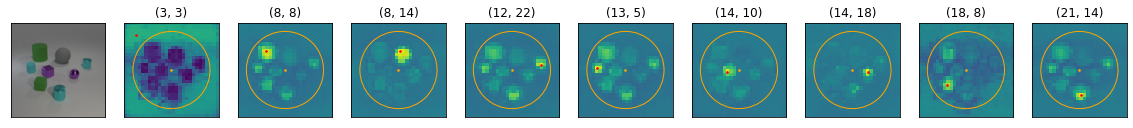

centering True
temperature 0.1


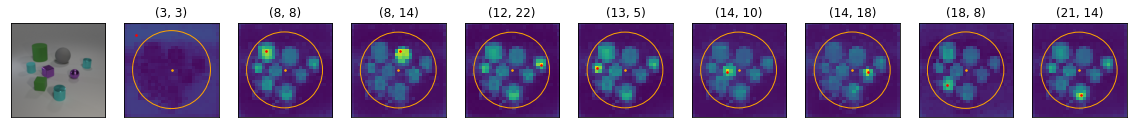

centering True
temperature 1


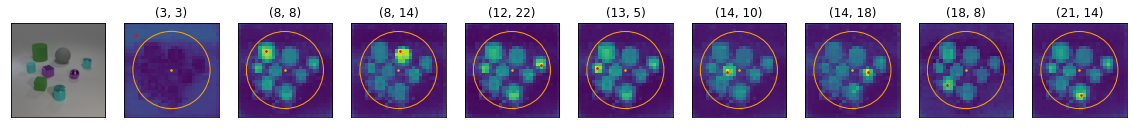

centering True
temperature 10


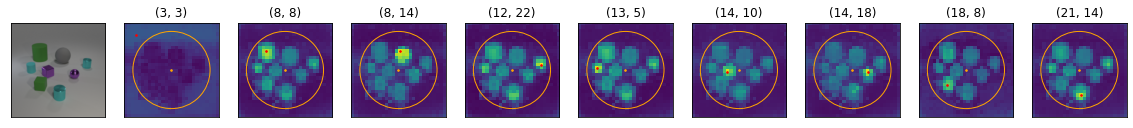

In [214]:
import math
from einops import rearrange, reduce, parse_shape
from osc.utils import cos_pairwise
from matplotlib.patches import Circle

def mu_sigma(sim):
    H, W, h, w = sim.shape
    # [h w 2]
    grid = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    grid = torch.stack(grid, dim=-1)

    # [H, W, h, w, _] * [_, _, h, w, 2] -> [H W 2]
    mus = reduce(
        sim[:, :, :, :, None] * grid[None, None, :, :, :],
        'H W h w two -> H W two',
        reduction='sum'
    )

    # [H, W, h, w] * || [_, _, h, w, 2] - [H, W, _, _, 2] ||^2 -> [H W]
    sigmas = reduce(
        sim[:, :, :, :] * (grid[None,None, :, :, :] - mus[:,:, None, None, :]).pow(2).sum(dim=-1),
        'H W h w -> H W',
        reduction='sum'
    )
    return mus, sigmas

b=1
a=0
H, W, C = x.shape[-3:]
cos = cos_pairwise(x[b, a])

for centering in [False, True]:
    for temperature in [0.1, 1, 10]:
        print('centering', centering)
        print('temperature', temperature)

        sim = rearrange(cos, 'H W h w -> H W (h w)')
        if centering:
            sim = sim - reduce(sim, 'H W hw -> () () hw', reduction='mean')
        sim = sim.div(temperature * np.sqrt(C)).softmax(-1)
        sim = rearrange(sim, 'H W (h w) -> H W h w', H=H, h=H)
        # sim[8, 14].zero_()
        # sim[8, 14, 2:12, 16:26].fill_(1/100)
        mus, sigmas = mu_sigma(sim)
        
        coords = [
            (3, 3),
            (8, 8),
            (8, 14),
            (12, 22),
            (13, 5),
            (14, 10),
            (14, 18),
            (18, 8),
            (21, 14),
        ]

        fig, axs = plt.subplots(1, 10, figsize=2.*np.array([10, 1]), facecolor='white')
        axs.flat[0].imshow(imgs_np[b, a])
        for ax, hw in zip(axs.flat[1:], coords):
            ax.set_title(str(hw))
            ax.imshow(sim[hw], interpolation='none', vmin=sim.min(), vmax=sim.max())
            ax.scatter(hw[1], hw[0], color='red', s=10, marker='.')
            ax.scatter(mus[hw][1], mus[hw][0], color='orange', s=10, marker='.')
            ax.add_patch(Circle((mus[hw][1], mus[hw][0]), radius=np.sqrt(sigmas[hw]), fill=False, color='orange'))
            
        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])
        display(fig)
        plt.close(fig)

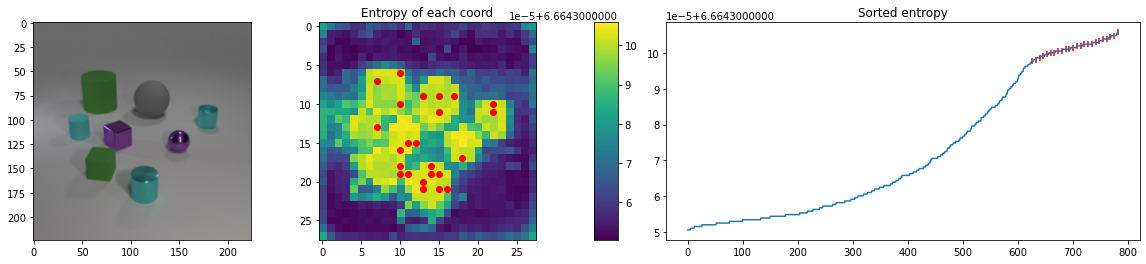

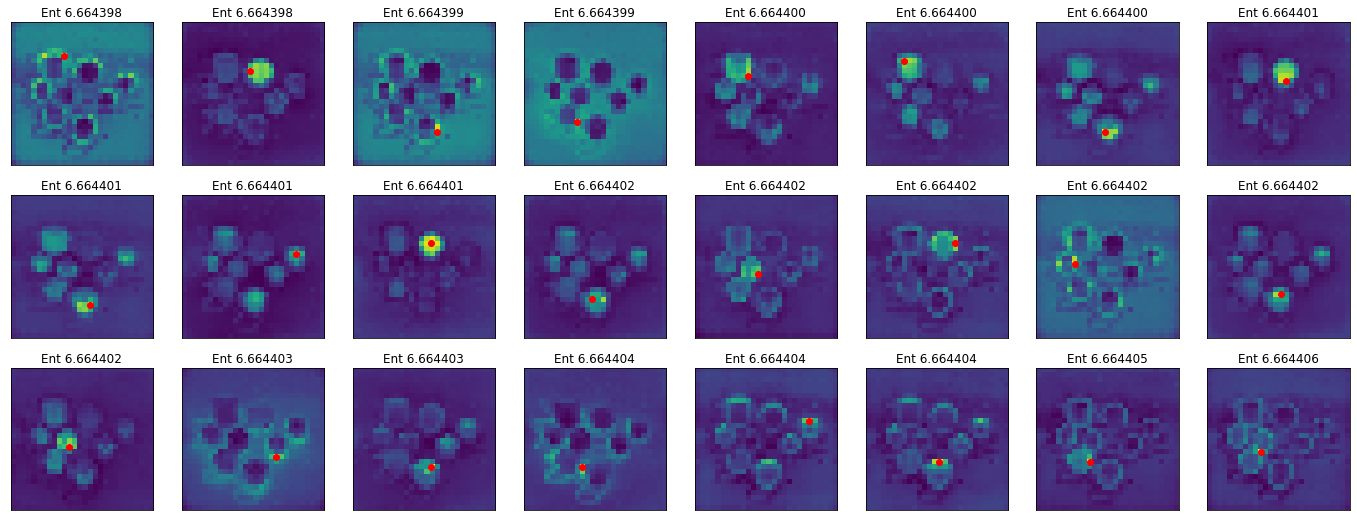

In [107]:
import math
from einops import rearrange, reduce, parse_shape
from osc.utils import cos_pairwise

b=1
a=0
cos = cos_pairwise(x[b, a])
cos = cos.div(np.sqrt(x.shape[-1]))
shape = parse_shape(cos, 'H W h w')
sim = rearrange(cos, 'H W h w -> (H W) (h w)')
sim = sim.softmax(-1)
ent = reduce(sim.neg() * sim.log(), 'HW hw -> HW', reduction='sum')
sort = torch.argsort(ent, dim=0)
sim = rearrange(sim, '(H W) (h w) -> H W h w', H=shape['H'], h=shape['h'])

select = np.linspace(round(.8*len(sort)), len(sort)-1, num=24, dtype=int)
fig, axs = plt.subplots(1, 4, figsize=(20, 4), facecolor='white', gridspec_kw={'width_ratios': [1, 1, .1, 2]})

ax = axs[0]
ax.imshow(imgs_np[b, a])
ax = axs[1]
im = ax.imshow(rearrange(ent, '(H W) -> H W', H=shape['H']))
ax.set_title('Entropy of each coord')
ax.scatter(*(np.unravel_index(sort[select], shape=(shape['H'], shape['W']))[::-1]), color='red')
fig.colorbar(im, cax=axs[2])
ax = axs[3]
ax.plot(ent[sort])
ax.scatter(select, ent[sort][select], color='red', marker='|')
ax.set_title('Sorted entropy')
display(fig)
plt.close(fig)

fig, axs = plt.subplots(math.ceil(len(select)/8), 8, figsize=3. * np.array([8, math.ceil(len(select)/8)]), facecolor='white')
for ax, hw in zip(axs.flat, sort[select]):
    ax.set_title(f'Ent {ent[hw]:7f}')
    hw = np.unravel_index(hw, shape=(shape['H'], shape['W']))
    ax.imshow(sim[hw])
    ax.scatter(hw[1], hw[0], color='red')
    ax.set_xticks([])
    ax.set_yticks([])
display(fig)
plt.close(fig)

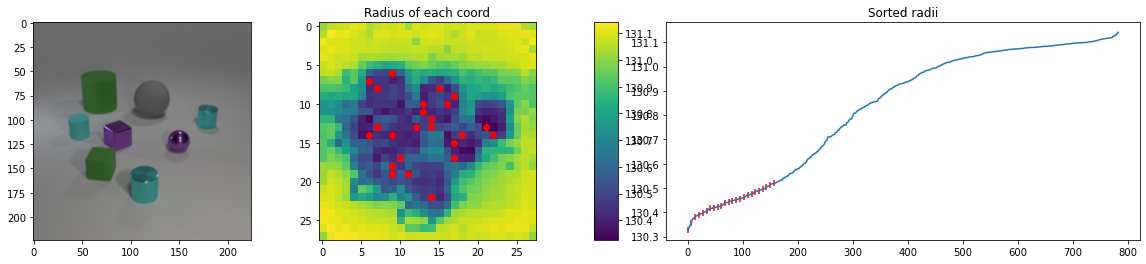

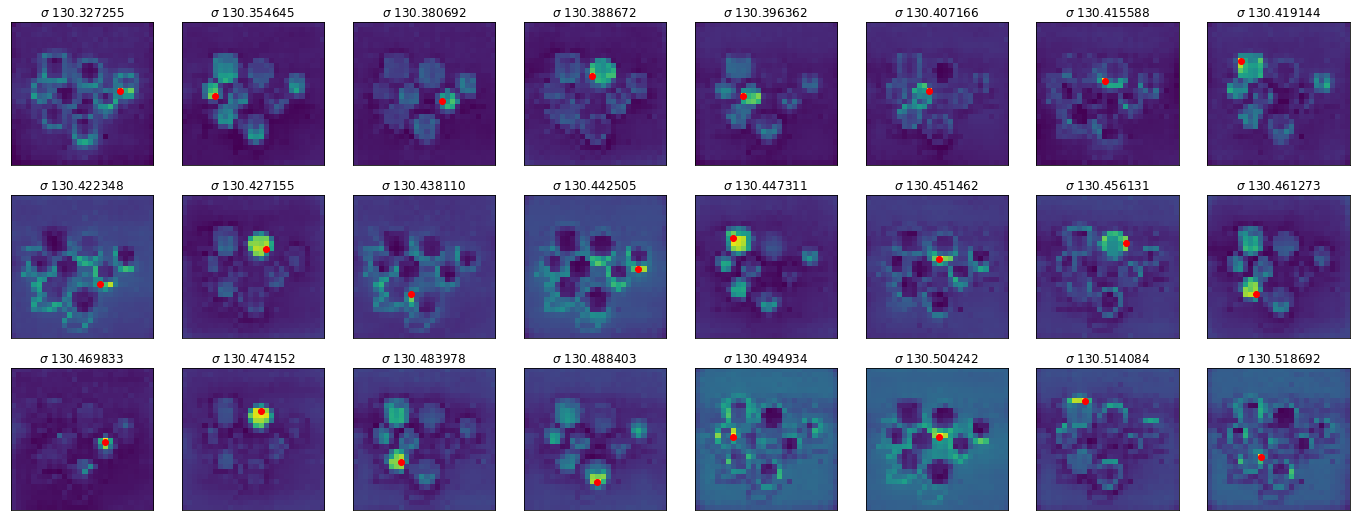

In [150]:
import math
from einops import rearrange, reduce, parse_shape
from osc.utils import cos_pairwise

# [H W 2]
grid = torch.meshgrid(torch.arange(shape['h']), torch.arange(shape['h']), indexing='ij')
grid = torch.stack(grid, dim=-1)
grid = rearrange(grid, 'h w two -> (h w) two')

b=1
a=0
cos = cos_pairwise(x[b, a])
shape = parse_shape(cos, 'H W h w')
sim = rearrange(cos, 'H W h w -> H W (h w)').div(np.sqrt(x.shape[-1])).softmax(-1)
# [H, W, hw, _] * [_, _, hw, 2] -> [H W 2]
mus = reduce(
    sim[:, :, :, None] * grid[None, None, :, :],
    'H W hw two -> H W two',
    reduction='sum'
)
# [H, W, hw] * || [_, _, hw, 2] - [H, W, _, 2] ||^2
sigmas = reduce(
    sim[:, :, :] * (grid[None,None, :, :] - mus[:,:, None, :]).pow(2).sum(dim=-1),
    'H W hw -> H W',
    reduction='sum'
)
sort = torch.argsort(rearrange(sigmas, 'H W -> (H W)'), dim=0)
sim = rearrange(sim, 'H W (h w) -> H W h w', h=shape['h'])

select = np.linspace(0, round(.2*len(sort)), num=24, dtype=int)
fig, axs = plt.subplots(1, 4, figsize=(20, 4), facecolor='white', gridspec_kw={'width_ratios': [1, 1, .1, 2]})

ax = axs[0]
ax.imshow(imgs_np[b, a])
ax = axs[1]
im = ax.imshow(sigmas)
ax.set_title('Radius of each coord')
ax.scatter(*(np.unravel_index(sort[select], shape=(shape['H'], shape['W']))[::-1]), color='red')
fig.colorbar(im, cax=axs[2])
ax = axs[3]
ax.plot(rearrange(sigmas, 'H W -> (H W)')[sort])
ax.scatter(select, rearrange(sigmas, 'H W -> (H W)')[sort[select]], color='red', marker='|')
ax.set_title('Sorted radii')
display(fig)
plt.close(fig)

fig, axs = plt.subplots(math.ceil(len(select)/8), 8, figsize=3. * np.array([8, math.ceil(len(select)/8)]), facecolor='white')
for ax, hw in zip(axs.flat, sort[select]):
    hw = np.unravel_index(hw, shape=(shape['H'], shape['W']))
    ax.set_title(f'$\sigma$ {sigmas[hw]:7f}')
    ax.imshow(sim[hw])
    ax.scatter(hw[1], hw[0], color='red')
    ax.set_xticks([])
    ax.set_yticks([])
display(fig)
plt.close(fig)

In [142]:
sigmas.min(), sigmas.max()

(tensor(130.3273), tensor(131.1411))

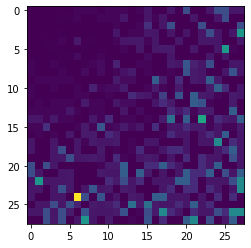

In [124]:
plt.imshow(sigmas)

In [111]:
select = np.linspace(round(.8*len(sort)), len(sort)-1, num=24, dtype=int)

fig, axs = plt.subplots(1, 4, figsize=(20, 4), facecolor='white', gridspec_kw={'width_ratios': [1, 1, .1, 2]})

ax = axs[0]
ax.imshow(imgs_np[b, a])
ax = axs[1]
im = ax.imshow(rearrange(ent, '(H W) -> H W', H=shape['H']))
ax.set_title('Entropy of each coord')
ax.scatter(*(np.unravel_index(sort[select], shape=(shape['H'], shape['W']))[::-1]), color='red')
fig.colorbar(im, cax=axs[2])
ax = axs[3]
ax.plot(ent[sort])
ax.scatter(select, ent[sort][select], color='red', marker='|')
ax.set_title('Sorted entropy')
display(fig)
plt.close(fig)

fig, axs = plt.subplots(math.ceil(len(select)/8), 8, figsize=3. * np.array([8, math.ceil(len(select)/8)]), facecolor='white')
for ax, hw in zip(axs.flat, sort[select]):
    ax.set_title(f'Ent {ent[hw]:7f}')
    hw = np.unravel_index(hw, shape=(shape['H'], shape['W']))
    ax.imshow(sim[hw])
    ax.scatter(hw[1], hw[0], color='red')
    ax.set_xticks([])
    ax.set_yticks([])
display(fig)
plt.close(fig)

AttributeError: module 'torch' has no attribute 'einops'

In [41]:
sim.shape

torch.Size([2, 392, 28, 28])

## Model and feature extraction

In [8]:
from timm.models.swin_transformer import swin_small_patch4_window7_224


@torch.no_grad()
def swin_forward(swin, imgs):
    B, C, H, W = imgs.shape
    x = swin.patch_embed(imgs)
    if swin.absolute_pos_embed is not None:
        x = x + swin.absolute_pos_embed
    x = swin.pos_drop(x)

    f_backbone = []
    for layer in swin.layers:
        for block in layer.blocks:
            x = block(x)
        f_backbone.append(x.reshape(B, *layer.input_resolution, layer.dim))
        if layer.downsample is not None:
            x = layer.downsample(x)

    f_global = reduce(swin.norm(x), "B HW C -> B C", reduction="mean")
    return f_global, f_backbone


swin = swin_small_patch4_window7_224(pretrained=True)
swin.eval()
f_global, f_backbone_all = swin_forward(
    swin, rearrange(imgs_th, "B A C H W -> (B A) C H W")
)
f_global = rearrange(f_global, "(B A) C -> B A C", B=B)
f_backbone_all = [rearrange(x, "(B A) H W C -> B A H W C", B=B) for x in f_backbone_all]
print("f_global", tuple(f_global.shape))
print("f_backbone_all:", *[tuple(o.shape) for o in f_backbone_all], sep="\n- ")

fpn_size = (56, 56)
f_backbone_up = [
    rearrange(
        torch.nn.functional.interpolate(
            rearrange(o, "B A H W C -> (B A) C H W"),
            size=fpn_size,
            mode="bilinear",
        ),
        "(B A) C H W -> B A H W C",
        B=B,
    )
    for o in f_backbone_all
]
print("f_backbone_up:", *[tuple(o.shape) for o in f_backbone_up], sep="\n- ")

fpn_dim = 128
torch.manual_seed(0)
f_backbone_fpn = sum(
    rearrange(
        torch.nn.functional.interpolate(
            rearrange(
                torch.nn.Linear(o.shape[-1], fpn_dim, bias=False)(o).detach(),
                "B A H W C -> (B A) C H W",
            ),
            size=fpn_size,
            mode="bilinear",
        ),
        "(B A) C H W -> B A H W C",
        B=B,
    )
    for o in f_backbone_all
)
print("f_backbone_fpn:", tuple(f_backbone_fpn.shape))

*_, H, W, C = f_backbone_fpn.shape  # num patches
Hp, Wp = Hi // H, Wi // W  # patch size in pixels

/home/fedbal/miniconda3/envs/iclr-osc-22/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755888534/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


f_global (2, 7, 768)
f_backbone_all:
- (2, 7, 56, 56, 96)
- (2, 7, 28, 28, 192)
- (2, 7, 14, 14, 384)
- (2, 7, 7, 7, 768)
f_backbone_up:
- (2, 7, 56, 56, 96)
- (2, 7, 56, 56, 192)
- (2, 7, 56, 56, 384)
- (2, 7, 56, 56, 768)
f_backbone_fpn: (2, 7, 56, 56, 128)


### Large global feats

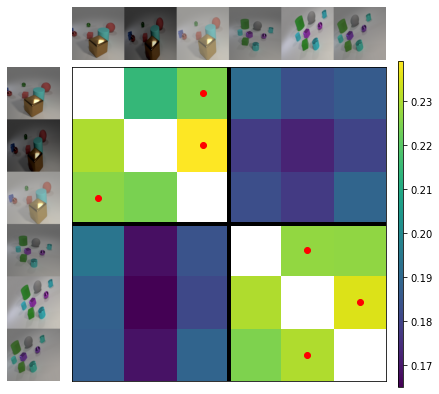

In [28]:
from osc.utils import cos_pairwise

f_global_large = f_global[:, :num_large]
cos = cos_pairwise(f_global_large).reshape(num_large * B, num_large * B)

fig, axs = plt.subplots(
    2,
    3,
    figsize=1.0 * np.array([1+num_large*B+0.1, 1+num_large*B]),
    gridspec_kw={
        "height_ratios": [1, num_large * B],
        "width_ratios": [1, num_large * B, 0.1],
        "hspace": 0,
        "wspace": 0.1,
    },
)
axs[0, 0].set_axis_off()
axs[0, 2].set_axis_off()

ax = axs[0, 1]
ax.imshow(rearrange(imgs_np[:, :num_large], "B A H W C -> H (B A W) C"))
ax.set_axis_off()

ax = axs[1, 0]
ax.imshow(rearrange(imgs_np[:, :num_large], "B A H W C -> (B A H) W C"))
ax.set_axis_off()

ax = axs[1, 1]
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(cos.fill_diagonal_(-torch.inf).softmax(-1).fill_diagonal_(torch.nan))
fig.colorbar(im, cax=axs[1, 2])
ax.scatter(cos.argmax(-1), np.arange(num_large * B), c="red")
ax.axvline(num_large - 0.5, c="black", lw=4)
ax.axhline(num_large - 0.5, c="black", lw=4);

### Small global feats

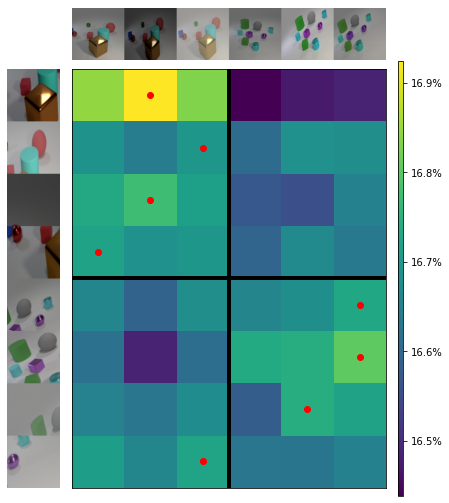

In [27]:
from matplotlib.ticker import PercentFormatter

f_global_large = f_global[:, :num_large]
f_global_small = f_global[:, -num_small:]
cos = cos_pairwise(f_global_small, f_global_large).reshape(num_small * B, num_large * B)

fig, axs = plt.subplots(
    2,
    3,
    figsize=1.0 * np.array([1+num_large*B+0.1, 1+num_small*B]),
    gridspec_kw={
        "height_ratios": [1, num_small * B],
        "width_ratios": [1, num_large * B, 0.1],
        "hspace": 0,
        "wspace": 0.1,
    },
)
axs[0, 0].set_axis_off()
axs[0, 2].set_axis_off()

ax = axs[0, 1]
ax.imshow(rearrange(imgs_np[:, :num_large], "B A H W C -> H (B A W) C"))
ax.set_axis_off()

ax = axs[1, 0]
ax.imshow(rearrange(imgs_np[:, -num_small:], "B A H W C -> (B A H) W C"))
ax.set_axis_off()

ax = axs[1, 1]
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(cos.div(np.sqrt(C)).softmax(-1))
fig.colorbar(im, cax=axs[1, 2], format=PercentFormatter(1, decimals=1))
ax.scatter(cos.argmax(-1), np.arange(num_small * B), c="red")
ax.axvline(num_large - 0.5, c="black", lw=4)
ax.axhline(num_small - 0.5, c="black", lw=4);

### Slot feats extraction

tensor(-3732563.7500)
tensor(-9360.0684)
in_proj_weight torch.Size([2304, 768])
out_proj.weight torch.Size([768, 768])
0
q tensor(-24.8248) tensor(2.8667) tensor(-7.6294e-05)
attn tensor(6.1250e-10) tensor(0.0181) tensor(126.0000)
1
q tensor(-24.5927) tensor(2.7802) tensor(-9.1553e-05)
attn tensor(1.9365e-10) tensor(0.0097) tensor(126.)
2
q tensor(-24.3754) tensor(2.7385) tensor(0.0001)
attn tensor(1.1428e-10) tensor(0.0068) tensor(126.)
3
q tensor(-24.3093) tensor(2.7129) tensor(-6.1035e-05)
attn tensor(7.4788e-11) tensor(0.0065) tensor(126.0000)


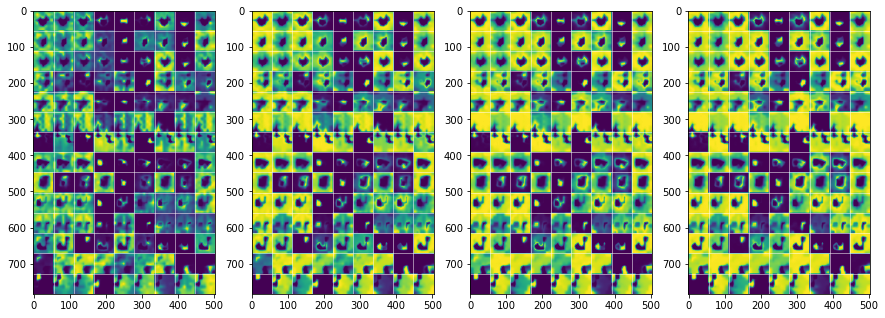

In [165]:
f_backbone = f_backbone_up[-1]
B, A, H, W, C = f_backbone.shape

k = rearrange(f_backbone, "B A H W C -> (B A) (H W) C")
print(k.sum())

# S = 9
# torch.manual_seed(42)
# q = torch.randn(S, C).expand(B*A, -1, -1)

S = 3**2
q = rearrange(
    F.grid_sample(
        rearrange(f_backbone, "B A H W C -> (B A) C H W"),
        torch.stack(
            torch.meshgrid(
                torch.linspace(-1, 1, int(np.sqrt(S)) + 2)[1:-1],
                torch.linspace(-1, 1, int(np.sqrt(S)) + 2)[1:-1],
                indexing="xy",
            ),
            dim=-1,
        ).expand(B * A, -1, -1, -1),
        align_corners=False,
    ),
    "BA C Sh Sw -> BA (Sh Sw) C",
)
print(q.sum())

plt.figure(figsize=(15, 10))

mhe = torch.nn.MultiheadAttention(C, 1, bias=False, batch_first=True)
mhe.in_proj_weight.requires_grad_(False)
for p in mhe.in_proj_weight.reshape(3, C, C):
    p.zero_().fill_diagonal_(1)
mhe.out_proj.weight.requires_grad_(False)
mhe.out_proj.weight.zero_().fill_diagonal_(1)
for n, p in mhe.named_parameters():
    print(n, p.shape)

def attention(q, k, v):
    C = q.shape[-1]
    scale = np.sqrt(C)
    dots = torch.einsum("...qc, ...kc -> ...qk", q, k).div(scale)
    attn = dots.softmax(-1)
    q = torch.einsum("...qk, ...kc -> ...qc", attn, v)
    return q, attn

def attention(q, k, v, *, pre_norm: bool, num_iters: int, competitive: bool):
    C = q.shape[-1]
    scale = np.sqrt(C)

    if pre_norm:
        k = F.layer_norm(k, (C,))
        v = F.layer_norm(v, (C,))

    for _ in range(num_iters):
        if pre_norm:
            q = F.layer_norm(q, (C,))
        dots = torch.einsum("...qc, ...kc -> ...qk", q, k).div(scale)

        if not competitive:
            attn = dots.softmax(-1)
        else:
            attn = dots.softmax(-2)
            attn = attn / attn.sum(-1, keepdim=True)

        q = torch.einsum("...qk, ...kc -> ...qc", attn, v)

    return q, attn

for i in range(4):
    print(i)
    
    q, attn = attention(ln(q),ln(k),ln(k), pre_norm=False, num_iters=1, competitive=True)
    # q, attn = mhe(ln(q),ln(k),ln(k))
    print('q', q.min(), q.max(), q.sum())
    print('attn', attn.min(), attn.max(), attn.sum())
    attn = (
        attn - reduce(attn, "B S HW -> B S ()", reduction="min")
    ) / (
        reduce(attn, "B S HW -> B S ()", reduction="max")
        - reduce(attn, "B S HW -> B S ()", reduction="min")
    )
    plt.subplot(1, 4, i+1)
    plt.imshow(rearrange(attn, 'B S (H W) -> (B H) (S W)', H=56))
    for h in range(56, 14*56, 56):
        plt.axhline(h-.5, color='white', lw=.5)
    for w in range(56, 9*56, 56):
        plt.axvline(w-.5, color='white', lw=.5)

plt.show()

f_objs    [B A S C]   2 7 9 768
attn_objs [B A S H W] 2 7 9 56 56
Sample 0


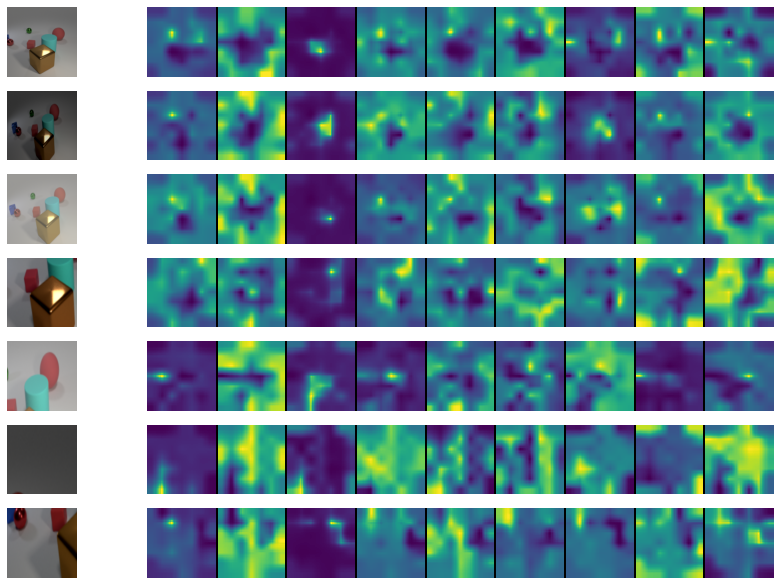

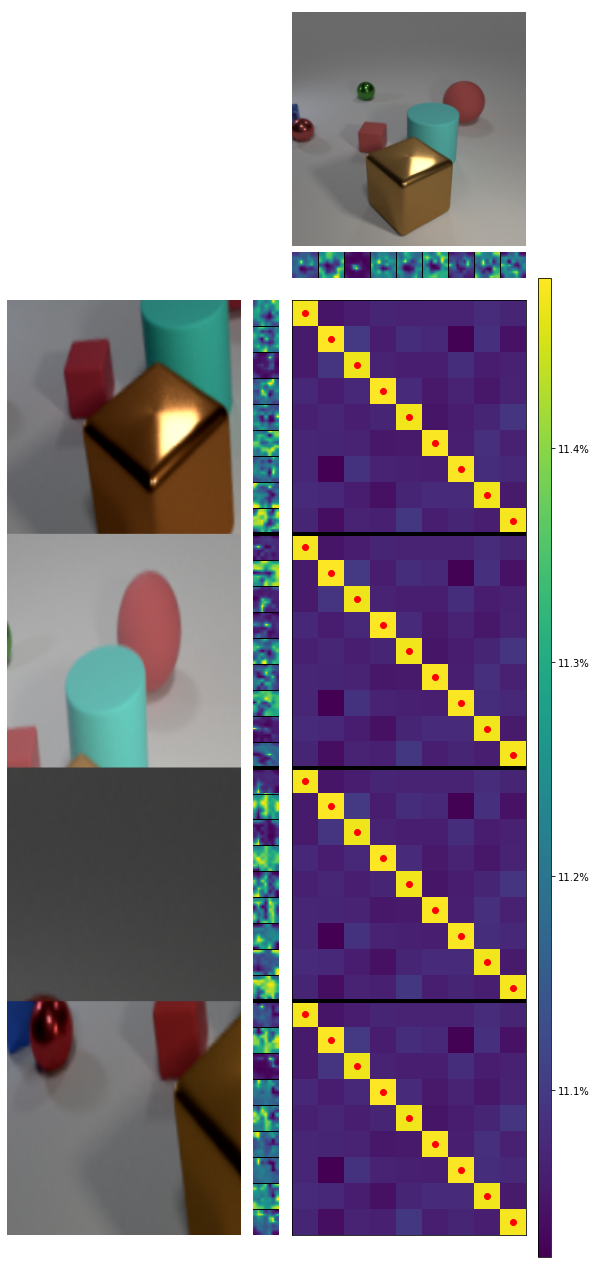

Sample 1


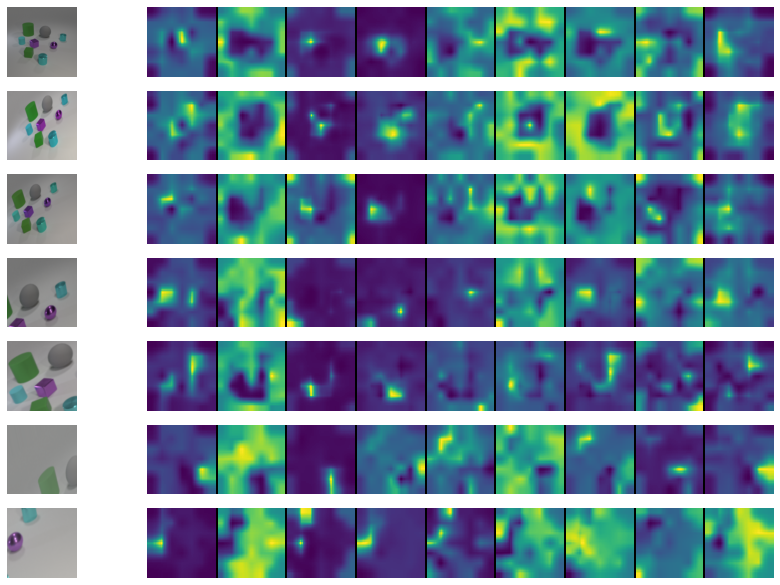

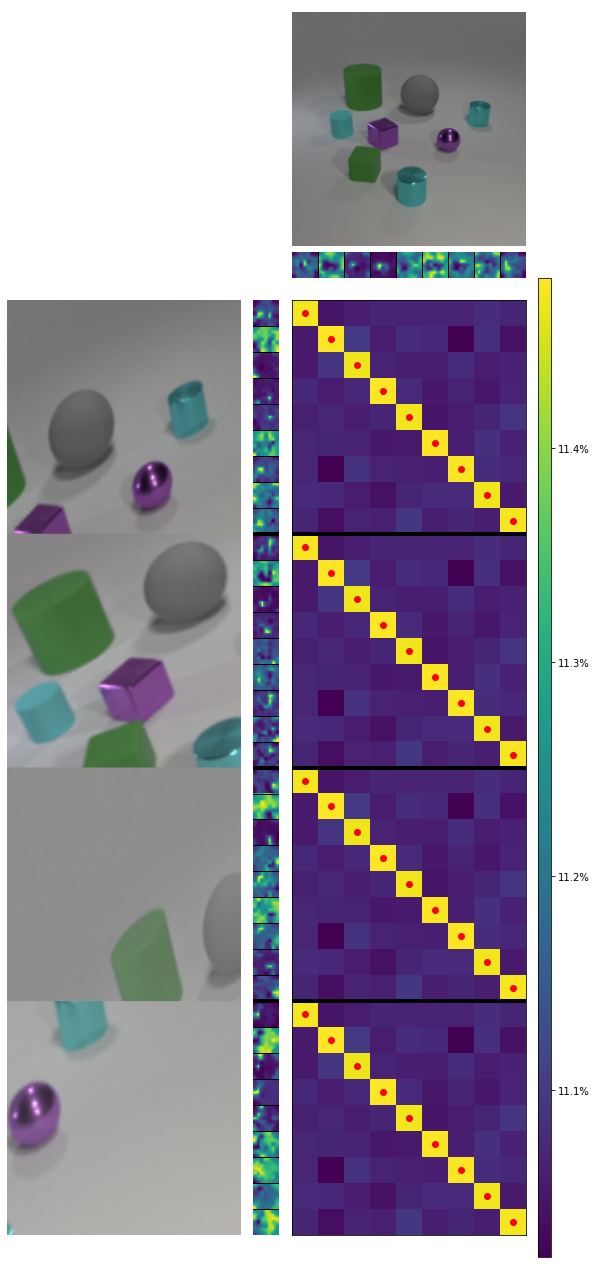

In [52]:
def attention(q, k, v, *, pre_norm: bool, num_iters: int, competitive: bool):
    C = q.shape[-1]
    scale = np.sqrt(C)

    if pre_norm:
        k = F.layer_norm(k, (C,))
        v = F.layer_norm(v, (C,))

    for _ in range(num_iters):
        if pre_norm:
            q = F.layer_norm(q, (C,))
        dots = torch.einsum("...qc, ...kc -> ...qk", q, k).div(scale)

        if not competitive:
            attn = dots.softmax(-1)
        else:
            attn = dots.softmax(-2)
            attn = attn / attn.sum(-1, keepdim=True)

        q = torch.einsum("...qk, ...kc -> ...qc", attn, v)

    return q



f_backbone = f_backbone_up[-1]
B, A, H, W, C = f_backbone.shape

# Where should query tokens come from?
queries_from = 'normal'
if queries_from == 'grid':
    S = 3**2
    q = rearrange(
        F.grid_sample(
            rearrange(f_backbone, "B A H W C -> (B A) C H W"),
            torch.stack(
                torch.meshgrid(
                    torch.linspace(-1, 1, int(np.sqrt(S)) + 2)[1:-1],
                    torch.linspace(-1, 1, int(np.sqrt(S)) + 2)[1:-1],
                    indexing="xy",
                ),
                dim=-1,
            ).expand(B * A, -1, -1, -1),
            align_corners=False,
        ),
        "BA C Sh Sw -> BA (Sh Sw) C",
    )
elif queries_from == 'normal':
    # Forget the per-img coord-based queries, just do S random vectors
    S = 9
    torch.manual_seed(42)
    q = 0.2 * torch.randn(S, C).expand(B*A, -1, -1)
else:
    raise NotImplementedError(queries_from)

k = rearrange(f_backbone, "B A H W C -> (B A) (H W) C")

# Update the queries with attention [(B A) S C] -> actually don't
# q = attention(q, k, k, pre_norm=True, num_iters=1, competitive=False)

f_objs = rearrange(q, "(B A) S C -> B A S C", B=B)
print("f_objs    [B A S C]  ", *f_objs.shape)

# Compute obj-patch similarity
attn_objs = (
    torch.einsum("...qc, ...kc -> ...qk", ln(q), ln(k)).div(np.sqrt(C)).softmax(-1)
)
attn_objs = (attn_objs - reduce(attn_objs, "BA S HW -> BA S ()", reduction="min")) / (
    reduce(attn_objs, "BA S HW -> BA S ()", reduction="max")
    - reduce(attn_objs, "BA S HW -> BA S ()", reduction="min")
)
attn_objs = rearrange(attn_objs, "(B A) S (H W) -> B A S H W", B=B, H=H)
print("attn_objs [B A S H W]", *attn_objs.shape)

for b in range(B):
    print("Sample", b)

    # For each obejct token, visualize similarity with patch tokens
    fig, axs = plt.subplots(
        A,
        2,
        figsize=1.5 * np.array([1 + S, A]),
        facecolor="white",
        gridspec_kw={"width_ratios": [1, S], "wspace": 0},
    )
    for a in range(A):
        axs[a, 0].imshow(imgs_np[b, a])
        axs[a, 1].imshow(
            rearrange(attn_objs[b, a], "S H W -> H (S W)"),
            interpolation="none",
            vmin=0,
            vmax=1,
        )
        for s in range(W, S * W, W):
            axs[a, 1].axvline(s - 0.5, color="black", lw=2)
    for ax in axs.flat:
        ax.set_axis_off()
    display(fig)
    plt.close(fig)

    # Each small crop is put in correspondence with its large crop (the original)
    f_objs_large = f_objs[b, 0]
    f_objs_small = f_objs[b, -num_small:]
    cos = cos_pairwise(f_objs_small, f_objs_large).reshape(num_small * S, S)

    fig, axs = plt.subplots(
        3,
        4,
        figsize=0.5 * np.array([S + 1 + S + 0.5, S + 1 + num_small * S]),
        gridspec_kw={
            "height_ratios": [S, 1, num_small * S],
            "width_ratios": [S, 1, S, 0.5],
            "hspace": 0,
            "wspace": .1
        },
        facecolor="white",
    )
    for ax in axs[:2, :2].flat:
        ax.set_axis_off()
    for ax in axs[:2, -1].flat:
        ax.set_axis_off()

    ax = axs[0, 2]
    ax.imshow(imgs_np[b, 0])
    ax.set_axis_off()

    ax = axs[1, 2]
    ax.imshow(rearrange(attn_objs[b, 0], "S H W -> H (S W)"), interpolation="none")
    ax.set_axis_off()
    for s in range(H, S * H, H):
        ax.axvline(s - 0.5, c="black", lw=1)

    ax = axs[2, 0]
    ax.imshow(rearrange(imgs_np[b, -num_small:], "A H W C -> (A H) W C"))
    ax.set_axis_off()

    ax = axs[2, 1]
    ax.imshow(
        rearrange(attn_objs[b, -num_small:], "A S H W -> (A S H) W"),
        interpolation="none",
    )
    ax.set_axis_off()
    for s in range(S * H, num_small * S * H, S * H):
        ax.axhline(s - 0.5, c="black", lw=4)
    for s in range(H, num_small * S * H, H):
        ax.axhline(s - 0.5, c="black", lw=1)

    ax = axs[2, 2]
    ax.set_xticks([])
    ax.set_yticks([])
    im = ax.imshow(cos.div(np.sqrt(C)).softmax(-1))
    fig.colorbar(im, cax=axs[2, 3], format=PercentFormatter(1, decimals=1))
    ax.scatter(cos.argmax(-1), np.arange(num_small * S), c="red")
    for s in range(S, num_small * S, S):
        ax.axhline(s - 0.5, c="black", lw=4)

    display(fig)
    plt.close(fig)

Image 0, large 0, small 0
(3, 3) (6, 6)


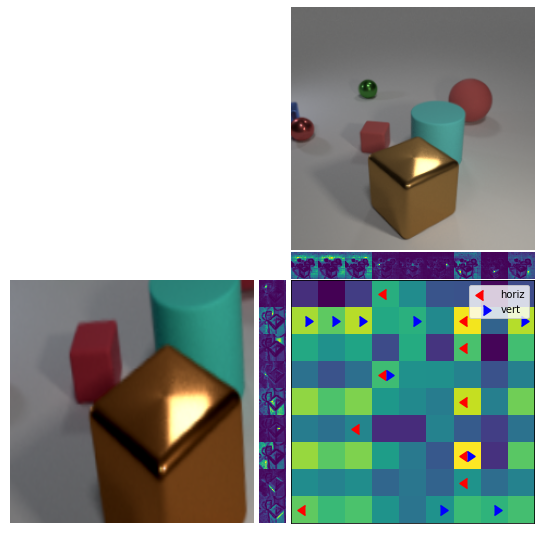

Image 0, large 0, small 1
(0, 0) (6, 4)


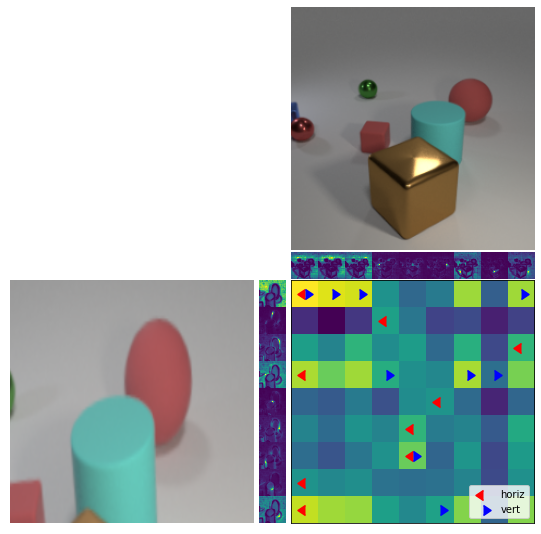

Image 0, large 0, small 2
(3, 0)


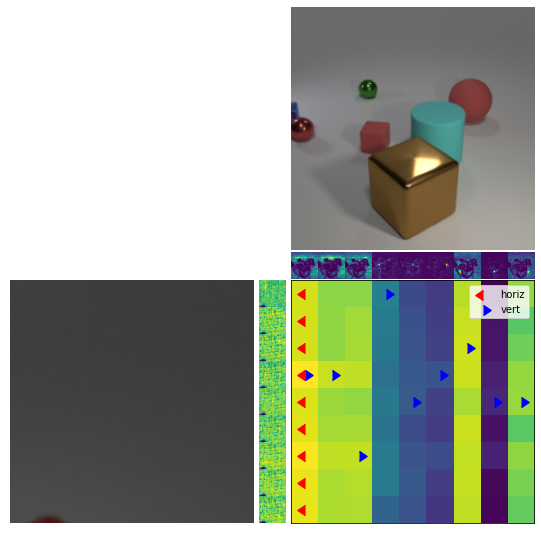

Image 0, large 0, small 3
(6, 0) (8, 4)


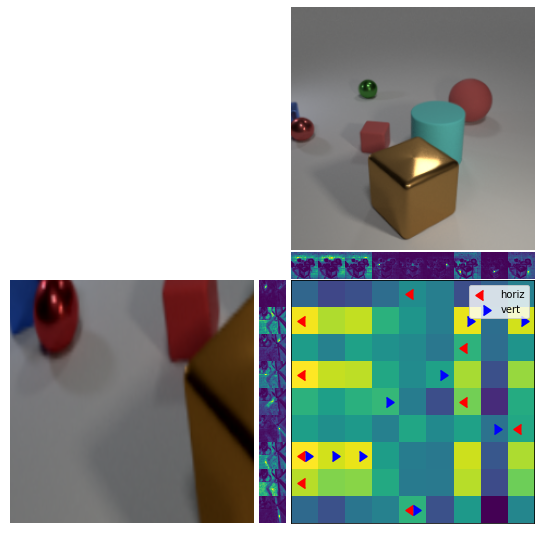

Image 1, large 0, small 0
(2, 8) (4, 4) (5, 7)


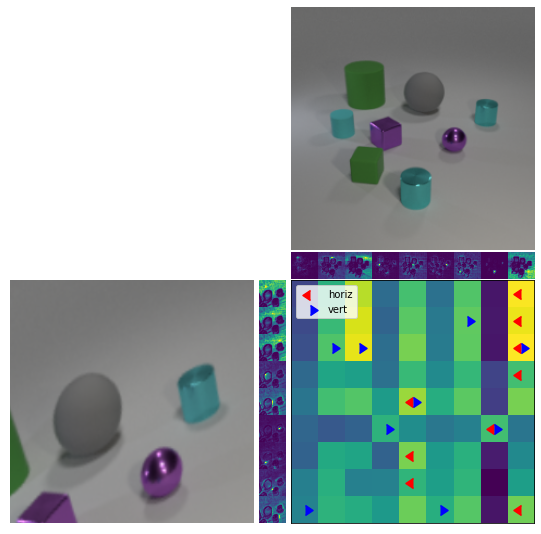

Image 1, large 0, small 1
(2, 8) (6, 3) (8, 4)


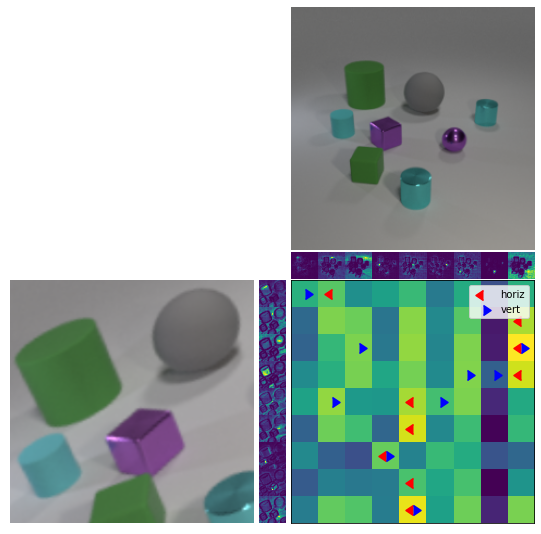

Image 1, large 0, small 2
(5, 8) (7, 0) (8, 4)


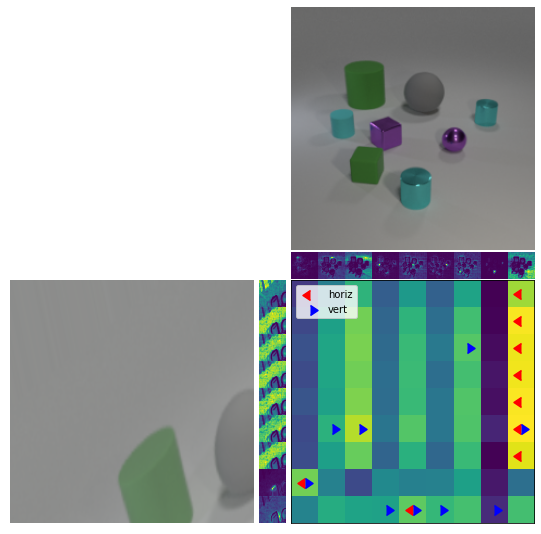

Image 1, large 0, small 3
(0, 5) (8, 8)


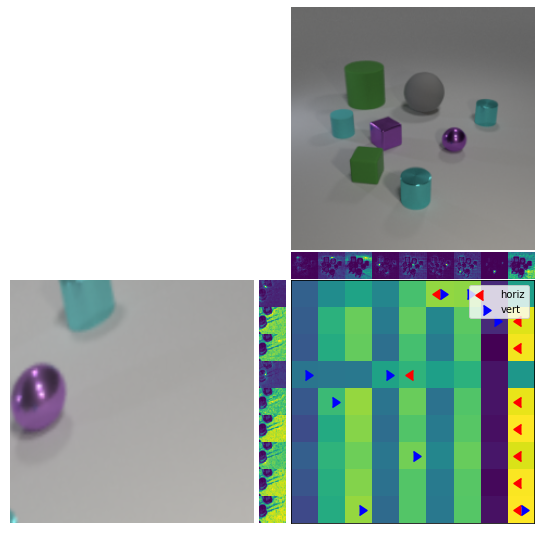

In [45]:
def argmax_lowe_horiz(x):
    # return max(-1), argmax(-1), and the ratio between
    # the largest and second largest value of softmax(x, -1)
    v, idx = torch.topk(x, k=2, dim=-1)
    lowe = torch.exp(v[:, 0] - v[:, 1])
    return v[:, 0], idx[:, 0], lowe

def argmax_lowe_vert(x):
    # return max(-2), argmax(-2), and the ratio between
    # the largest and second largest value of softmax(x, -2)
    v, idx = torch.topk(x, k=2, dim=-2)
    lowe = torch.exp(v[0, :] - v[1, :])
    return v[0,:], idx[0, :], lowe

cos_all = cos_pairwise(f_objs).div(np.sqrt(f_objs.shape[-1]))

for b in range(B):
    i = 0 # large crop
    for j in range(num_small): # small crop
        print(f'Image {b}, large {i}, small {j}')
        cos = cos_all[b, num_large+j, :, b, i, :]

        fig, axs = plt.subplots(
            3,
            3,
            figsize=0.5 * np.array([S + 1 + S, S + 1 + S]),
            gridspec_kw={
                "height_ratios": [S, 1, S],
                "width_ratios": [S, 1, S],
                "hspace": 0.01,
                "wspace": 0.01
            },
            facecolor="white",
        )
        for ax in axs.flat:
            ax.set_axis_off()
        axs[2, 0].imshow(imgs_np[b, num_large+j])
        axs[0, 2].imshow(imgs_np[b, i])
        axs[2, 2].imshow(cos)
        axs[2, 2].set_axis_on()
        axs[2, 2].set_xticks([])
        axs[2, 2].set_yticks([])

        _, idx_h, lowe = argmax_lowe_horiz(cos)
        axs[2,2].scatter(idx_h, np.arange(len(idx_h)), color='red', marker=8, s=100, label='horiz')
        lowe = lowe>=1.5
        axs[2,2].scatter(idx_h[lowe], np.arange(len(idx_h))[lowe], color='black', marker=8, s=40)

        _, idx_v, lowe = argmax_lowe_vert(cos)
        lowe = lowe>=1.5
        axs[2,2].scatter(np.arange(len(idx_v)), idx_v, color='blue', marker=9, s=100, label='vert')
        axs[2,2].scatter(np.arange(len(idx_v))[lowe], idx_v[lowe], color='black', marker=9, s=40)
        axs[2,2].legend()
        
        is_reciprocal = idx_v[idx_h] == torch.arange(len(idx_h))
        print(*zip(np.arange(len(idx_h))[is_reciprocal], idx_h[is_reciprocal].tolist()))
        
        axs[1, 2].imshow(rearrange(attn_objs[b, i], "S H W -> H (S W)"), interpolation="none")
        axs[2, 1].imshow(rearrange(attn_objs[b, num_large+j], "S H W -> (S H) W"), interpolation="none")

        display(fig)
        plt.close(fig)

In [172]:
import fvcore

ModuleNotFoundError: No module named 'fvcore'

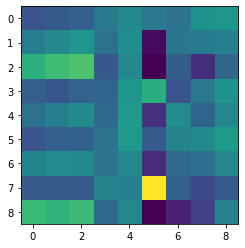

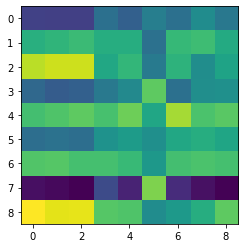

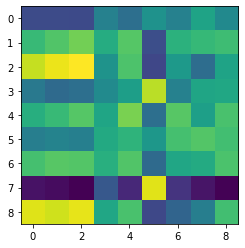

In [48]:
plt.imshow(cos_all[b, i, :, b, j, :].softmax(-1))
plt.show()
plt.imshow(cos_all[b, i, :, b, j, :].softmax(-2))
plt.show()

plt.imshow(torch.minimum(cos_all[b, i, :, b, j, :].softmax(-1), cos_all[b, i, :, b, j, :].softmax(-2)))
plt.show()
